0.0015 0.00015


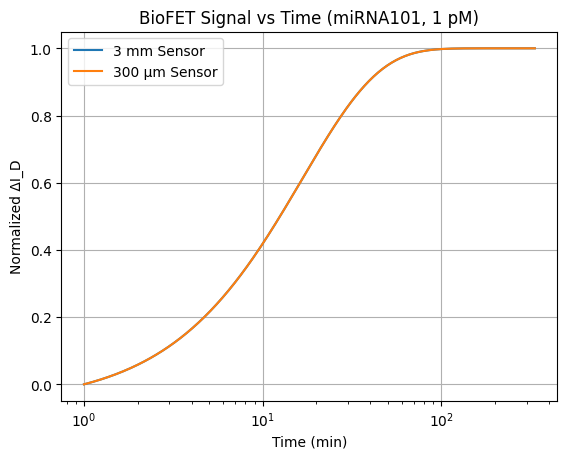

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
k_B = 1.38e-23      # Boltzmann constant (J/K)
T = 298             # Room temperature (K)
q = 1.6e-19         # Elementary charge (C)
N_A = 6.022e23      # Avogadro's number

# Target molecule: miRNA-101
bp_count = 23
charge_per_bp = -1 * q  # Each base contributes ~-1e in solution
miRNA_charge = bp_count * charge_per_bp  # Total charge per miRNA

# Geometry
drop_volume = 10e-6  # 10 µL
sensor_radii = np.array([1.5e-3, 0.15e-3])  # 3 mm and 300 µm diameter
diffusion_length = drop_volume/(np.pi * sensor_radii**2)  # Estimate height of drop in m
print(sensor_radii[0],sensor_radii[1])

# Diffusion constant for miRNA (approx, small RNA in water)
D_miRNA = 5e-11  # m^2/s

# Kinetics parameters
kon = 1e6  # M^-1 s^-1 (association rate)
koff = 1e-3  # s^-1 (dissociation rate)
Kd = koff / kon

# Probe density estimation
probe_conc = 1e-6  # 1 µM in mol/L
probe_surf_density = probe_conc * N_A * 1e-3  # convert L to m^3

# Target concentration
target_conc = 1e-12  # 1 pM in mol/L
target_total = target_conc * N_A * drop_volume  # number of molecules

# Time array (1 min to 2 hrs)
time = np.logspace(np.log10(60), np.log10(20000), 300)  # seconds

# Function to simulate signal with transport-limited + kinetic model
def simulate_signal(sensor_radius):
    A = np.pi * sensor_radius**2
    V = drop_volume
    L = diffusion_length

    # Effective number of probes (assume 10% of max SAM density ~ 1e12/cm2)
    probe_density = 1e12 * 1e4  # per m^2
    probes_total = probe_density * A

    # Diffusion-limited capture estimate
    C0 = target_conc * 1e3  # mol/m^3
    flux = D_miRNA * C0 / L  # mol/m^2/s
    capture_rate = flux * A * N_A  # #/s

    # Kinetic model: Langmuir binding with influx
    bound = np.zeros_like(time)
    dt = np.diff(time, prepend=time[0])
    n_bound = 0
    for i in range(1, len(time)):
        influx = capture_rate * dt[i]
        binding = kon * (probes_total - n_bound) * (target_conc) * dt[i]
        unbinding = koff * n_bound * dt[i]
        n_bound += binding - unbinding
        n_bound = min(n_bound, probes_total)
        bound[i] = n_bound

    # Assume signal is proportional to charge bound
    signal = -bound * miRNA_charge
    delta_ID = signal / np.max(np.abs(signal))  # normalize to max response

    return time / 60, delta_ID  # in minutes

# Run for both sensor sizes
time_min_large, signal_large = simulate_signal(sensor_radii[0])
time_min_small, signal_small = simulate_signal(sensor_radii[1])

# Plotting
plt.figure()
plt.plot(time_min_large, signal_large, label='3 mm Sensor')
plt.plot(time_min_small, signal_small, label='300 µm Sensor')
plt.xlabel('Time (min)')
plt.ylabel('Normalized ΔI_D')
plt.title('BioFET Signal vs Time (miRNA101, 1 pM)')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()
